In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
train_dir = r"C:\Users\HP\Downloads\chest_xray\train"
val_dir = r"C:\Users\HP\Downloads\chest_xray\val"
test_dir = r"C:\Users\HP\Downloads\chest_xray\test"

In [10]:
import os
# Print subdirectories
print("Train subfolders:", os.listdir(train_dir))
print("Validation subfolders:", os.listdir(val_dir))
print("Test subfolders:", os.listdir(test_dir))

Train subfolders: ['NORMAL', 'PNEUMONIA']
Validation subfolders: ['NORMAL', 'PNEUMONIA']
Test subfolders: ['NORMAL', 'PNEUMONIA']


In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation only for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Validation data
val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Test data
test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # important: don't shuffle for test
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input
input_tensor = Input(shape=(224, 224, 3))

# Base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

callbacks = [
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1,
        mode='min'
    ),
    
    CSVLogger(
        filename='training_log.csv',
        append=True
    )
]

In [30]:
history_frozen = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5073 - loss: 0.8219
Epoch 1: val_loss improved from inf to 0.68474, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.5075 - loss: 0.8216 - val_accuracy: 0.5000 - val_loss: 0.6847 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6018 - loss: 0.6828
Epoch 2: val_loss improved from 0.68474 to 0.64879, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.6019 - loss: 0.6827 - val_accuracy: 0.5000 - val_loss: 0.6488 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6706 - loss: 0.6272
Epoch 3: val_loss improved from 0.64879 to 0.63696, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.6707 - loss: 0.6271 - val_accuracy: 0.5625 - val_loss: 0.6370 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc

In [31]:
# Unfreeze last 30 layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [32]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

In [33]:
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  
    callbacks=callbacks
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7619 - loss: 0.5453
Epoch 1: val_loss did not improve from 0.60146
163/163 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.7622 - loss: 0.5448 - val_accuracy: 0.5000 - val_loss: 1.0610 - learning_rate: 1.0000e-05
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8717 - loss: 0.3576
Epoch 2: val_loss improved from 0.60146 to 0.57582, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.8716 - loss: 0.3576 - val_accuracy: 0.7500 - val_loss: 0.5758 - learning_rate: 1.0000e-05
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8933 - loss: 0.2978
Epoch 3: val_loss improved from 0.57582 to 0.47457, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.8933 - loss: 0.2979 - val_accuracy: 0.6875 - val_loss: 0.4746 - learning_rate: 1.0000e-05
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8842 - loss: 0.3169
Epoch

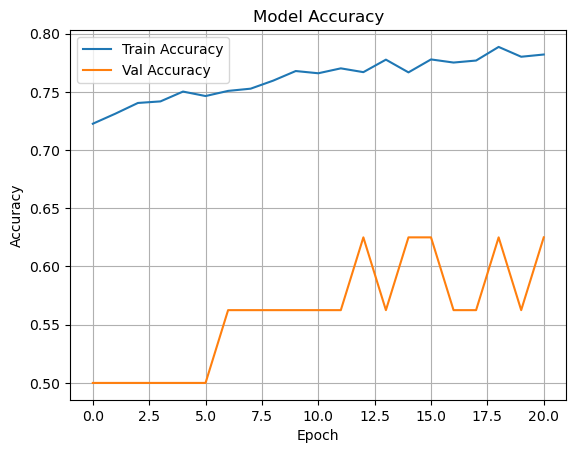

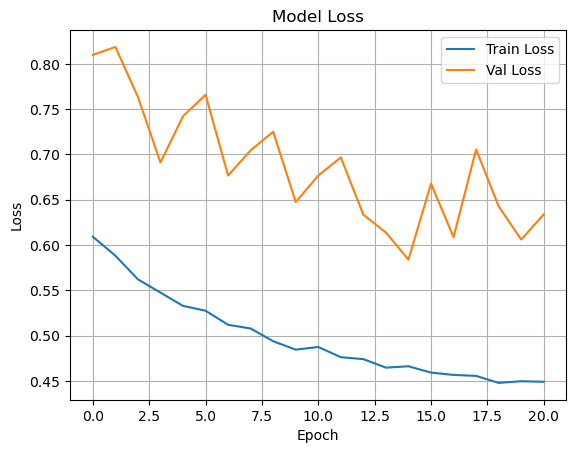

In [34]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [59]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.keras")

In [66]:
print(train_data.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Raw prediction probability: 0.0000


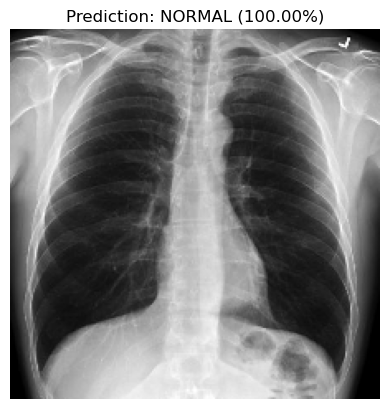

In [70]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = r"C:\Users\HP\Downloads\noorm.jpg"

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = best_model.predict(img_array)
prob = prediction[0][0]

# Debug output
print(f"Raw prediction probability: {prob:.4f}")

# Final result
if prob > 0.5:
    label = 'PNEUMONIA'
    confidence = prob
else:
    label = 'NORMAL'
    confidence = 1 - prob

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Raw prediction probability: 0.9661


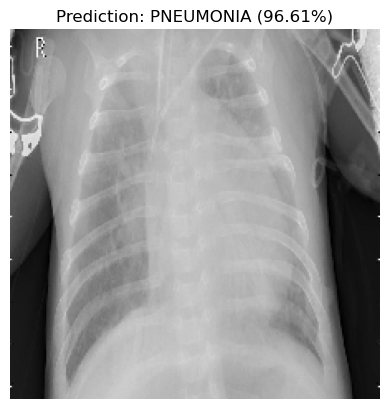

In [68]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = r"C:\Users\HP\Downloads\chest_xray\test\PNEUMONIA\person1_virus_7.jpeg"

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = best_model.predict(img_array)
prob = prediction[0][0]

# Debug output
print(f"Raw prediction probability: {prob:.4f}")

# Final result
if prob > 0.5:
    label = 'PNEUMONIA'
    confidence = prob
else:
    label = 'NORMAL'
    confidence = 1 - prob

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
plt.show()

In [43]:
# Extract metrics
train_accuracies = history_finetune.history['accuracy']
val_accuracies = history_finetune.history['val_accuracy']
val_losses = history_finetune.history['val_loss']

# Find the best epochs
best_train_acc = max(train_accuracies)
best_val_acc = max(val_accuracies)
best_val_loss = min(val_losses)

best_epoch = val_accuracies.index(best_val_acc) + 1  # +1 for human-friendly (starts from 1)

print(f"📊 Best Training Accuracy: {best_train_acc:.4f}")
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f}")
print(f"💡 Best Validation Loss: {best_val_loss:.4f} (at Epoch {best_epoch})")

📊 Best Training Accuracy: 0.9260
✅ Best Validation Accuracy: 0.8125
💡 Best Validation Loss: 0.4296 (at Epoch 8)


In [49]:
!pip install opencv-python-headless

   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
    --------------------------------------- 0.8/38.9 MB 4.2 MB/s eta 0:00:10
   - -------------------------------------- 1.3/38.9 MB 3.2 MB/s eta 0:00:12
   - -------------------------------------- 1.8/38.9 MB 3.1 MB/s eta 0:00:13
   -- ------------------------------------- 2.4/38.9 MB 2.8 MB/s eta 0:00:14
   -- ------------------------------------- 2.9/38.9 MB 2.6 MB/s eta 0:00:14
   --- ------------------------------------ 3.4/38.9 MB 2.7 MB/s eta 0:00:14
   ---- ----------------------------------- 4.2/38.9 MB 2.8 MB/s eta 0:00:13
   ---- ----------------------------------- 4.7/38.9 MB 2.7 MB/s eta 0:00:13
   ----- ---------------------------------- 5.2/38.9 MB 2.7 MB/s eta 0:00:13
   ----- ---------------------------------- 5.8/38.9 MB 2.8 MB/s eta 0:00:13
   ------ --------------------------------- 6.6/38.9 MB 2.8 MB/s eta 0:00:12
   ------- -------------------------------- 7.1/38.9 MB 2.8 MB/s eta 0:00:12
   ---

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name='conv5_block3_out'):
    img_array = get_img_array(img_path, size=(224, 224))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


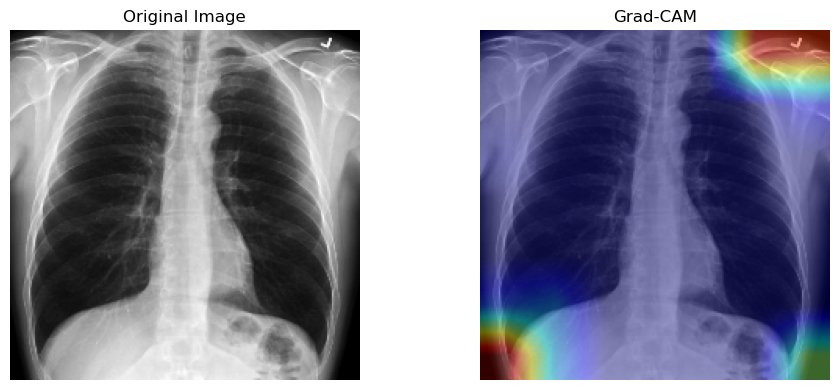

In [54]:
display_gradcam(r"C:\Users\HP\Downloads\noorm.jpg", model)

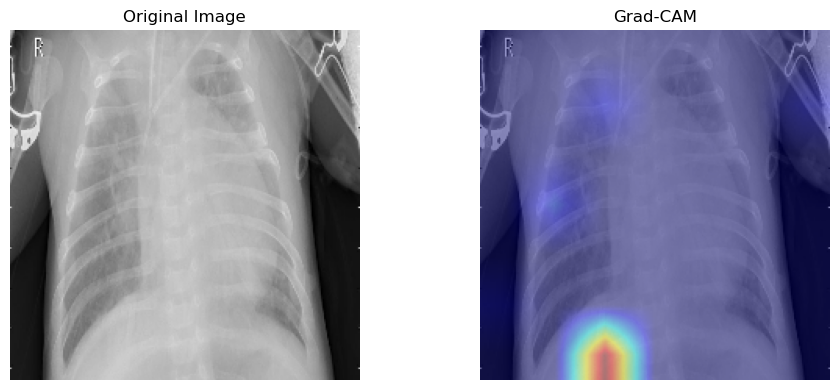

In [69]:
display_gradcam(r"C:\Users\HP\Downloads\chest_xray\test\PNEUMONIA\person1_virus_7.jpeg", model)